In [1]:
import pandas as pd
import numpy as np
from model import cleaned_fr
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import MinMaxScaler, RobustScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [3]:
# Models in experiment 1
models = {
            'BernoulliNB' : BernoulliNB(),
            'GaussianNB' : GaussianNB(),
            'DTr' : DecisionTreeClassifier(),
            'ExTrs': ExtraTreesClassifier(),
            'KNeigh' : KNeighborsClassifier(),
            'svc': SVC(probability=True),
            'xgb' : XGBClassifier(),
            'logistic' : LogisticRegression(),
            'MLP' : MLPClassifier()
        }

In [4]:
# Importing cleaned frame
df = cleaned_fr()

# Separating
X, y = df.iloc[:, :-1], df.iloc[:, -1]

# Select binary columns to avoid scaling below
binary_cols = X.select_dtypes('uint8').columns

# Remaining columns
non_binary_cols = [col for col in X.columns if col not in binary_cols]

# Times to repeat Kfold instance
rKF = RepeatedKFold(n_repeats=34, n_splits=3, random_state=23)

In [5]:
# Transformer that scales the non-binary columns and does nothing to the binary columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), non_binary_cols),
        ('bin', FunctionTransformer(None, validate=False), binary_cols) # does nothing
    ])

_folds, _names, _accuracy, _precision, _recall, _f1, _auc, _set_type = [], [], [], [], [], [], [], []

for MODEL_NAME, ML_MODEL in models.items():
    for fold_id, (train_index, test_index) in enumerate(rKF.split(X)):
        
        # Train test split
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_test, y_test = X.iloc[test_index], y.iloc[test_index] 

        # Pipeline for training
        _local_pipe = Pipeline([
                                ('preprocessor', preprocessor),
                                (MODEL_NAME, ML_MODEL)
                            ])

        # Fitting
        _local_pipe.fit(X_train, y_train)

        # Test the results in training and test to check for overfitting
        lab = {'train' : (X_train, y_train), 'test': (X_test, y_test)}

        for lab_type, (X1,Y1) in lab.items():

            # Keeping len
            _folds.append(fold_id)
            _names.append(MODEL_NAME)
            _set_type.append( lab_type )

            # Predictions
            y_pred = _local_pipe.predict(X1)

            # Proba for AUC
            y_proba = _local_pipe.predict_proba(X1)[:, 1]  # Probabilities for the positive class
            _auc.append( roc_auc_score(Y1, y_proba) )
            
            # Metrics
            _accuracy.append( accuracy_score(Y1, y_pred) )
            _precision.append( precision_score(Y1, y_pred) )
            _recall.append( recall_score(Y1, y_pred) ) #<-- intended
            _f1.append( f1_score(Y1, y_pred) )

In [6]:
# Saving in DataFrame
result_df = pd.DataFrame( {'fold_id':_folds, 'model_name':_names, 'set': _set_type, 'accuracy':_accuracy, 'precision':_precision, 'recall':_recall, 'f1':_f1, 'auc':_auc} )

In [7]:
# Quick  look to the average performance
result_df.groupby(by=['model_name','set']).agg({'mean'}).loc[:,'recall'].unstack().droplevel(0,axis=1).filter(['train','test']).sort_values(by=['test'], ascending=False)

set,train,test
model_name,,
svc,0.922556,0.921735
MLP,0.921616,0.918370
GaussianNB,0.920259,0.917693
xgb,0.925043,0.917514
BernoulliNB,0.909704,0.909776
logistic,0.914421,0.907028
KNeigh,0.916918,0.905545
ExTrs,0.920281,0.886023
DTr,0.920281,0.883432


In [8]:
# Quick  look to the average performance
result_df.groupby(by=['model_name','set']).agg({'std'}).loc[:,'recall'].unstack().droplevel(0,axis=1).filter(['train','test']).sort_values(by=['test'])

set,train,test
model_name,,
svc,0.017024,0.033867
MLP,0.016571,0.035808
BernoulliNB,0.018462,0.036642
xgb,0.017293,0.037232
logistic,0.018360,0.038257
GaussianNB,0.015361,0.038802
KNeigh,0.019251,0.041238
ExTrs,0.017235,0.052254
DTr,0.017235,0.052770


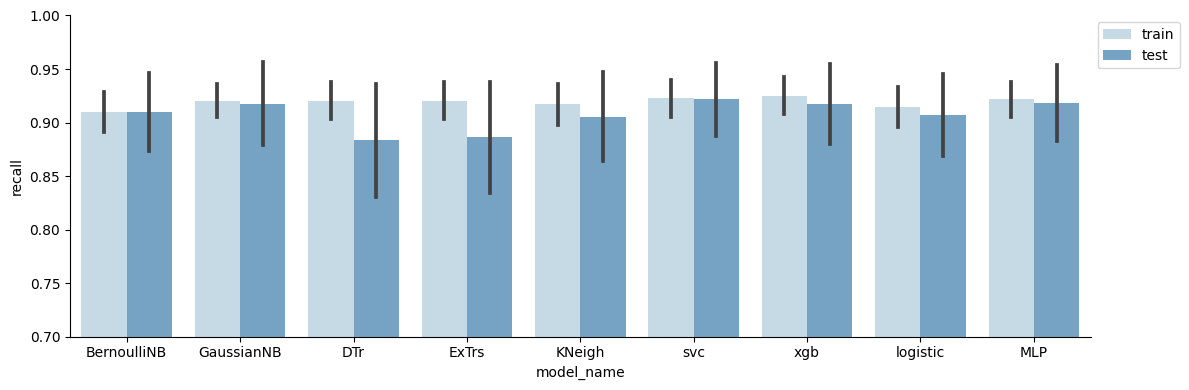

In [9]:
fig, ax = plt.subplots(figsize=(12,4))

sns.barplot(
    data = result_df.filter(['fold_id', 'model_name', 'set'] + ["recall"]),
    x="model_name", y="recall", hue="set",
    palette="Blues", alpha=.75, ax=ax, errorbar='sd'
)

sns.despine(top=True, right=True)

# Set y-axis limits
ax.set_ylim(0.7, 1)

# Move legend outside of the plot
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()  # Adjust layout so everything fits nicely
plt.savefig('experiment1_recall.png', dpi=200 )
plt.show()

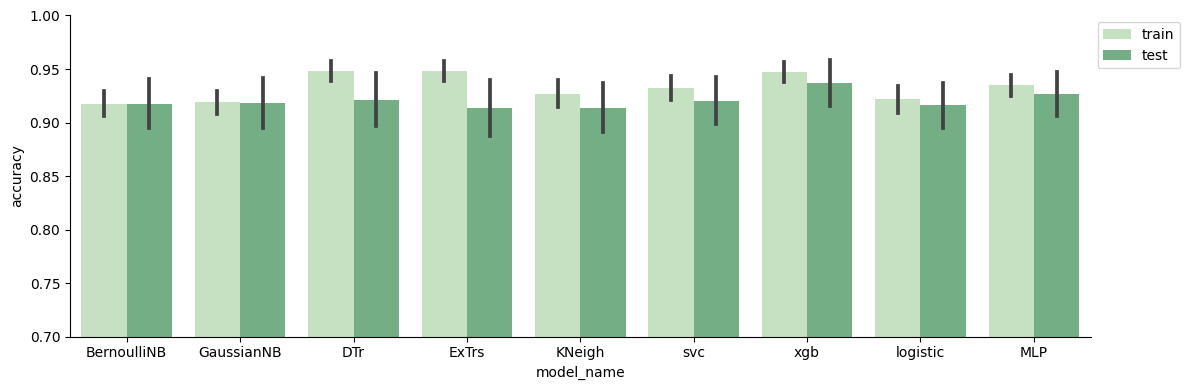

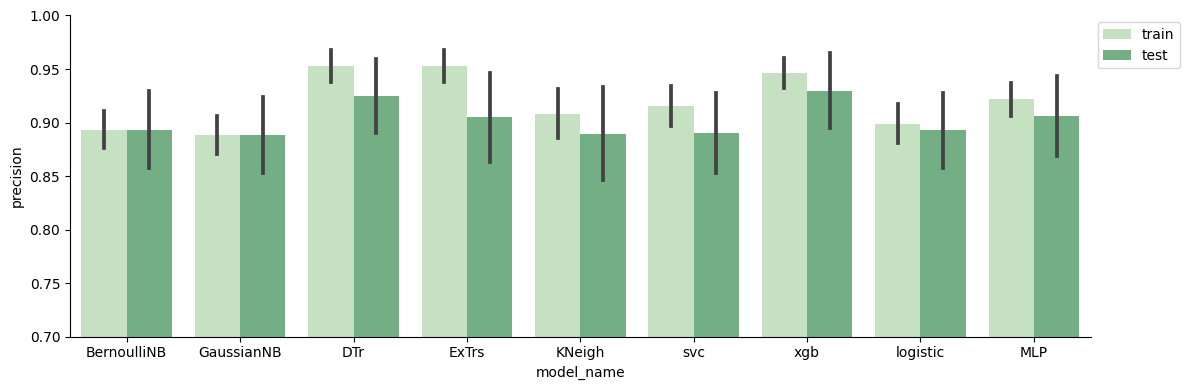

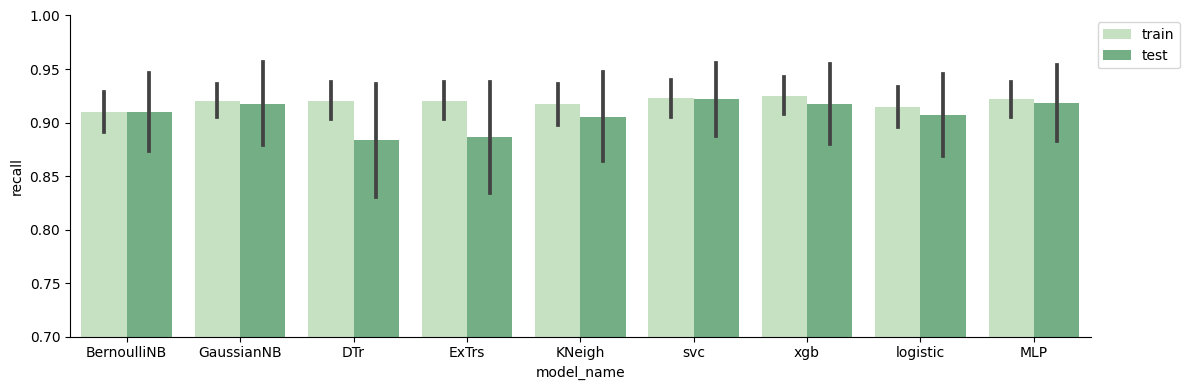

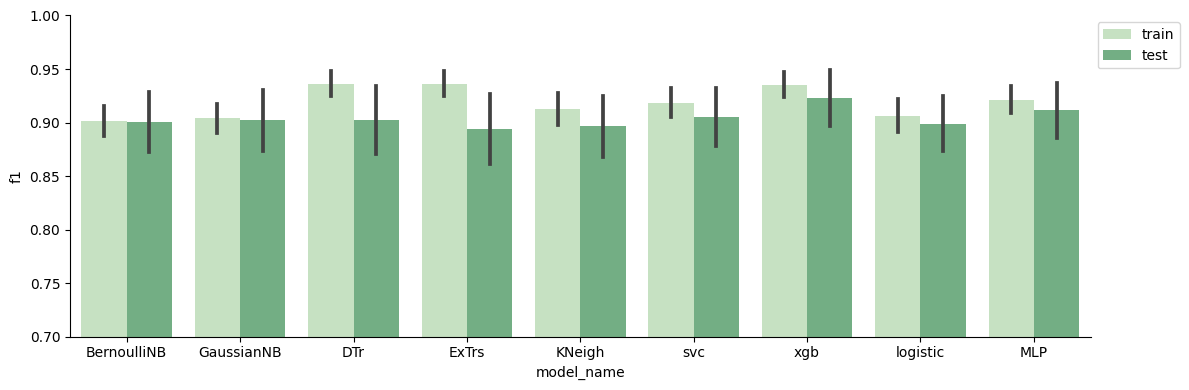

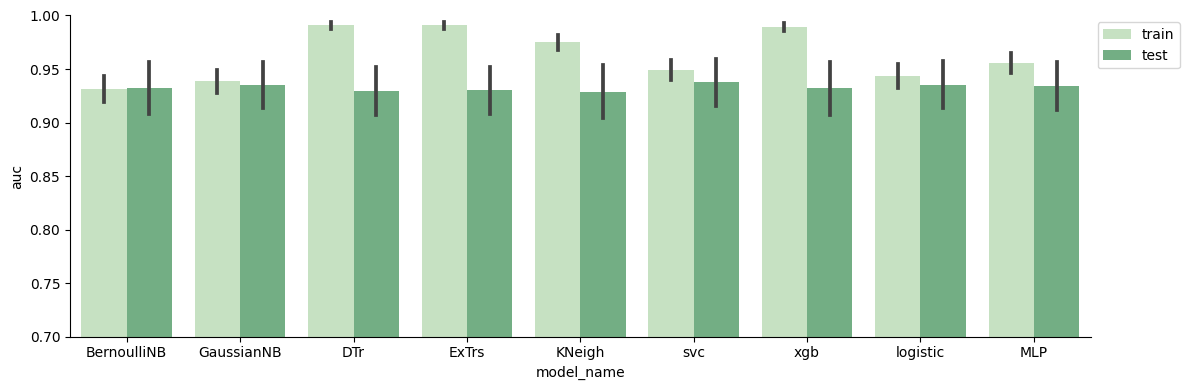

In [10]:
for metric in result_df.columns[3:]:

    fig, ax = plt.subplots(figsize=(12,4))

    sns.barplot(
        data = result_df.filter(['fold_id', 'model_name', 'set'] + [metric]),
        x="model_name", y=metric, hue="set",
        palette="Greens", alpha=.75, ax=ax, errorbar='sd'
    )

    sns.despine(top=True, right=True)

    # Set y-axis limits
    ax.set_ylim(0.7, 1)

    # Move legend outside of the plot
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()  # Adjust layout so everything fits nicely
    plt.show()

In [11]:
# Saving Result
result_df.to_csv('Data/SystolicResultsExperiment1.csv')

# Experiment 2

Based on experiment 1 results for recall, which measures the rate of values correctly predicted positive and the real positive, we designate for further exploration and/or hyperparameter fine-tunning the models:

* _GaussianNB_ (no fine-tunning required)
* _MLP_.
* _SVC_: With the highest average recall and the lowest std. We could extract more value from it.

Let's try to find parameters that improve the performance of the default parametrization

## MLP Parameter tunning

In [12]:
from sklearn.model_selection import GridSearchCV

In [13]:
# Model to tune
model = MLPClassifier()

# Recalling the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), non_binary_cols),
        ('bin', FunctionTransformer(None, validate=False), binary_cols) # does nothing
    ])

_search_pipe = Pipeline([
                        ('preprocessor', preprocessor),
                        ('MLP', model)
                    ])

# Parameters for grid search
param_grid = {
    'MLP__hidden_layer_sizes': [(200,), (200,100),(300,200,100), (200,100,50), (300,200,100)],
    'MLP__activation': ['logistic','tanh','relu'],
    'MLP__solver': ['lbfgs', 'adam'],# Limited-memory Broyden, Fletcher, Goldfarb, and Shanno (L-BFGS) optimization method

#     Determines the optimization algorithm to use for adjusting the weights.
# 'lbfgs': An optimizer in the family of quasi-Newton methods, known for being robust but potentially slow for large datasets.
# 'adam': A stochastic gradient descent optimizer that considers adaptive learning rates for different parameters. It's generally recommended for large datasets and complex models.
# Different solvers can significantly affect the training speed and model performance, especially in terms of convergence and the ability to escape local minima. 

		'MLP__max_iter': [200,300,400],
    'MLP__early_stopping': [True], # Adding these last two parameters to make sure the loop doesn't get stuck unwantedly and shorten execution time
    'MLP__validation_fraction': [.25] #25% of the training data is used for this purpose, allowing the model to validate learning progress and adjust accordingly without using the test set.
}

grid_search = GridSearchCV(_search_pipe, param_grid, cv=5, verbose=1, scoring='recall')
grid_search.fit(X, y)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 90 candidates, totalling 450 fits


In [ ]:
# Getting the best parameters
mlp_parameters = {key[5:] : val for key, val in grid_search.best_params_.items()}

# Dropping unwanted parameters
mlp_parameters.pop('early_stopping')
mlp_parameters.pop('validation_fraction')

print("Selected Parameters:", mlp_parameters)

# Getting the best mlp parameters from the dictionary above
best_mlp_model = MLPClassifier( **mlp_parameters )

Selected Parameters: {'activation': 'tanh', 'hidden_layer_sizes': (200, 100), 'max_iter': 200, 'solver': 'adam'}


## SVC Parameter tunning


In [ ]:
# Model to tune
model = SVC()

# Recalling the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), non_binary_cols),
        ('bin', FunctionTransformer(None, validate=False), binary_cols) # does nothing
    ])

_search_pipe = Pipeline([
                        ('preprocessor', preprocessor),
                        ('TunedSVC', model)
                    ])

# Parameters for grid search
param_grid = {
    'TunedSVC__kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
    'TunedSVC__degree' : [1,2,3,4,5],
    'TunedSVC__C' : [.1,.2,.3,.4,.5,.6,.7,.8,.9,1],
    'TunedSVC__probability' : [True] 
}

grid_search = GridSearchCV(_search_pipe, param_grid, cv=5, verbose=1, scoring='recall')
grid_search.fit(X, y)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation Recall: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best parameters: {'TunedSVC__C': 0.1, 'TunedSVC__degree': 1, 'TunedSVC__kernel': 'linear', 'TunedSVC__probability': True}
Best cross-validation Recall: 0.8968


In [ ]:
#best_svc_model = SVC( **{key[10:] : val for key, val in grid_search.best_params_.items()} )
best_svc_model = SVC(probability=True)

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

In [ ]:
# Models in Final Experiment
models = {
    'GaussianNB' : GaussianNB(),
    'bestMLP' : best_mlp_model,
    'bestSVC': best_svc_model
}

# Creating Stacking classifier
_stack = StackingClassifier( estimators=list(models.items()), final_estimator=LogisticRegression())

# Adding Votting
_soft = VotingClassifier(estimators=list(models.items()), voting='soft')
_hard = VotingClassifier(estimators=list(models.items()), voting='hard')

# Adding Keys to Dict
models['stacked'] = _stack
models['soft_vote'] = _soft
models['hard_vote'] = _hard

In [ ]:
# Importing cleaned frame
df = cleaned_fr()

# Separating
X, y = df.iloc[:, :-1], df.iloc[:, -1]

# Times to repeat Kfold instance (Aumented repetitions)
rKF = RepeatedKFold(n_repeats=100, n_splits=3, random_state=23)

In [ ]:
# Transformer that scales the non-binary columns and does nothing to the binary columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), non_binary_cols),
        ('bin', FunctionTransformer(None, validate=False), binary_cols) # does nothing
    ])

_folds, _names, _accuracy, _precision, _recall, _f1, _auc, _set_type = [], [], [], [], [], [], [], []

for MODEL_NAME, ML_MODEL in models.items():
    for fold_id, (train_index, test_index) in enumerate(rKF.split(X)):
        
        # Train test split
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_test, y_test = X.iloc[test_index], y.iloc[test_index] 

        # Pipeline for training
        _local_pipe = Pipeline([
                                ('preprocessor', preprocessor),
                                (MODEL_NAME, ML_MODEL)
                            ])

        # Fitting
        _local_pipe.fit(X_train, y_train)

        # Test the results in training and test to check for overfitting
        lab = {'train' : (X_train, y_train), 'test': (X_test, y_test)}

        for lab_type, (X1,Y1) in lab.items():

            # Keeping len
            _folds.append(fold_id)
            _names.append(MODEL_NAME)
            _set_type.append( lab_type )

            # Predictions
            y_pred = _local_pipe.predict(X1)
            
            # Metrics
            _accuracy.append( accuracy_score(Y1, y_pred) )
            _precision.append( precision_score(Y1, y_pred) )
            _recall.append( recall_score(Y1, y_pred) ) #<-- intended
            _f1.append( f1_score(Y1, y_pred) )

In [ ]:
# Saving in DataFrame
result2_df = pd.DataFrame( {'fold_id':_folds, 'model_name':_names, 'set': _set_type, 'accuracy':_accuracy, 'precision':_precision, 'recall':_recall, 'f1':_f1} )

In [ ]:
# Quick  look to the average performance
result2_df.groupby(by=['model_name','set']).agg({'mean'}).loc[:,'recall'].unstack().droplevel(0,axis=1).filter(['train','test']).sort_values(by=['test'], ascending=False)

set,train,test
model_name,,
bestSVC,0.922569,0.922063
soft_vote,0.922178,0.920353
hard_vote,0.921885,0.920270
GaussianNB,0.920406,0.918238
stacked,0.920612,0.917984
bestMLP,0.919284,0.913289


In [ ]:
# Quick  look to the performance std
result2_df.groupby(by=['model_name','set']).agg({'std'}).loc[:,'recall'].unstack().droplevel(0,axis=1).filter(['train','test']).sort_values(by=['test'])

set,train,test
model_name,,
bestSVC,0.015586,0.031295
hard_vote,0.015475,0.032702
soft_vote,0.015373,0.032913
bestMLP,0.017643,0.033291
stacked,0.014633,0.034813
GaussianNB,0.014061,0.035787


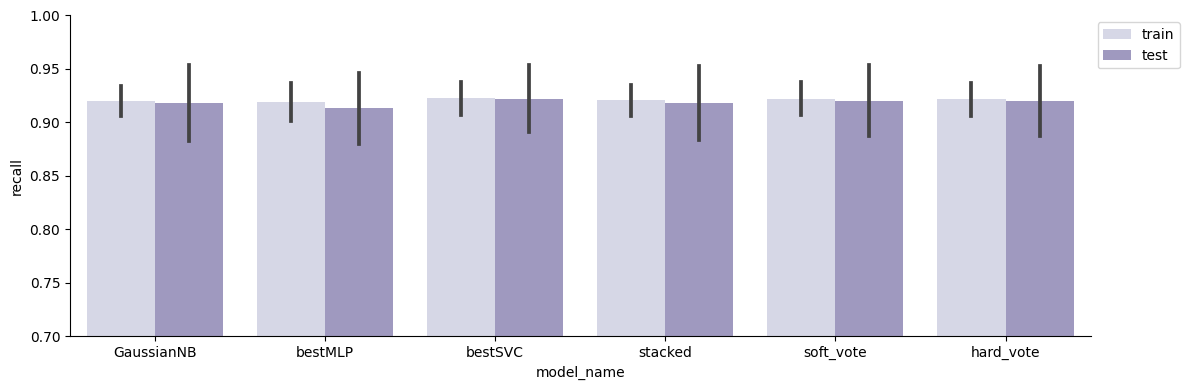

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))

sns.barplot(
    data = result2_df.filter(['fold_id', 'model_name', 'set'] + ["recall"]),
    x="model_name", y="recall", hue="set",
    palette="Purples", alpha=.75, ax=ax, errorbar='sd'
)

sns.despine(top=True, right=True)

# Set y-axis limits
ax.set_ylim(0.7, 1)

# Move legend outside of the plot
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()  # Adjust layout so everything fits nicely
plt.savefig('experiment2_recall.png', dpi=200 )
plt.show()

In [ ]:
# Save the results
result2_df.to_csv('Data/SystolicResultsFinalExperiment.csv')

Performance between the models named _bestMLP, GaussianNB, _bestSVC and stacked_ are quite similar. Therefore, since the model will be deployed in a web front-end chossing a simpler model is preferred, and in terms of recall we're not risking a performance detriment (*decrease performance*), therefore, let's keep the  bestSVC as our selected model.

# Saving Selected Model


In [ ]:
from model import train_and_save_model

In [ ]:
train_and_save_model('ModelSystolic_SVC', best_svc_model)